In [9]:
import os
os.environ['OMP_NUM_THREADS']='4'

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from dolfin import *

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.solver import stokes_uzawa
from reaktoro_transport.solver import transient_adv_diff_DG

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

/home/powei/anaconda3/envs/fenics36/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [10]:
class tracer_transport_problem:
    # This is the base class of single component tracer transport
    def __init__(self):
        pass
    
    def set_mesh(self, mesh, boundary_markers):
        # Setup FeNiCs mesh and boundary markers
        self.mesh = mesh
        self.boundary_markers = boundary_markers
        
    def set_pressure_boundary_conditions(self, pressure_bc_dict, pressure_bc_list):
        self.pressure_bc_dict = pressure_bc_dict
        self.pressure_bc_list = pressure_bc_list
    
    def solve_stokes(self, max_steps, res_target, omega_num, r_num):
        self.u, self.p, res_list = stokes_uzawa(self.mesh, self.boundary_markers, self.pressure_bc_dict, \
                                                self.pressure_bc_list, max_steps=max_steps, res_target=res_target,\
                                                omega_num=omega_num, r_num=r_num)
        
        return self.u, self.p
    
    
    def set_flow_field(self):
        V = VectorFunctionSpace(self.mesh, "Crouzeix-Raviart", 1)
        #Q = FunctionSpace(self.mesh, "DG", 0)
        self.u = Function(V)
        
        xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/pv_output.xdmf')
        xdmf_obj.read_checkpoint(self.u, 'velocity', 0)
        xdmf_obj.close()

    def set_transport_boundary_conditions(self, transport_bc_dict, transport_bc_list):
        self.transport_bc_dict = transport_bc_dict
        self.transport_bc_list = transport_bc_list
    
    def solve_transport(self, source, D_num, init_cond, dt_num, steps, theta_num):
        u_list = transient_adv_diff_DG(self.mesh, self.boundary_markers, self.u, source,\
                                     D_num, init_cond, dt_num, steps, theta_num)
        
        return u_list
        

In [11]:
# Reading mesh and MeshFunction that stores the fluid solid markers
mesh_xdmf = Mesh()

xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_mesh.xdmf')
xdmf_obj.read(mesh_xdmf)

boundary_markers = MeshFunction('size_t', mesh_xdmf, dim=1)

xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_boundary.xdmf')
xdmf_obj.read(boundary_markers)

xdmf_obj.close()

In [12]:
p_bc_dict = {'inlet': [2, 3], 'noslip': [4], }
p_dirichlet_list = [1.0, 0.0]

In [13]:
%%time

problem = tracer_transport_problem()
problem.set_mesh(mesh_xdmf, boundary_markers)
#problem.set_pressure_boundary_conditions(p_bc_dict, p_dirichlet_list)
problem.set_flow_field()
#velocity, pressure = problem.solve_stokes(max_steps=50, res_target=1e-13, omega_num=500.0, r_num=400.0)

CPU times: user 19.6 ms, sys: 147 µs, total: 19.8 ms
Wall time: 19.7 ms


In [14]:
%%time

init_cond = Expression('0.0', degree=1)
#problem.set_transport_boundary_conditions()
u_list = problem.solve_transport(Constant(0.0), 1e-4, init_cond, dt_num=0.5, steps=500, theta_num=0.5)

CPU times: user 11.2 s, sys: 248 ms, total: 11.4 s
Wall time: 11.1 s


In [15]:
xdmf_obj = XDMFFile(MPI.comm_world, 'solute.xdmf')

xdmf_obj.write(u_list[-1], 0)

xdmf_obj.close()

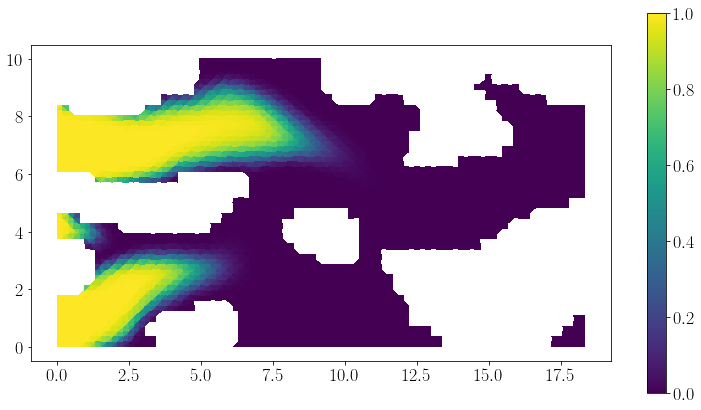

In [16]:
fig = plt.figure(figsize=(13,7))
#plot(mesh_xdmf)
cb = plot(u_list[-1])
#plot(velocity)
fig.colorbar(cb)
plt.show()